<a href="https://colab.research.google.com/github/sheilaftria/Beecycle-Exploratory-Data-Analysis-in-Google-BigQuery/blob/main/Beecycle_Data_Analysis_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting Google Big Query to Google Colab

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%load_ext google.cloud.bigquery

In [ ]:
%%bigquery --project  ds-bootcamp-sheila

SELECT * 
FROM ` ds-bootcamp-sheila.dibimbing.dim_product`

Executing query with job ID: d8a6689b-3fac-4002-bfea-6abdef8c3cc1
Query executing: 0.33s


ERROR:
 400 Invalid project ID ' ds-bootcamp-sheila'. Project IDs must contain 6-63 lowercase letters, digits, or dashes. Some project IDs also include domain name separated by a colon. IDs must start with a letter and may not end with a dash.

Location: US
Job ID: d8a6689b-3fac-4002-bfea-6abdef8c3cc1



# Customer Distribution Based on Gender and Age

To identify BeeCycle's target customer, a query was performed to view the distribution of customers based on their gender and age.

For the age category, customers were divided into groups using the CASE WHEN function as follows:

* Customers aged 20 or below were grouped as 'Group <=20'

* Customers aged between 21 and 40 were grouped as 'Group 21 - 40'

* Customers aged between 41 and 60 were grouped as 'Group 41 - 60'

* Customers aged over 60 were grouped as 'Group >60'


**Which grouping age and gender have the highest number of transactions in BeeCycle?**

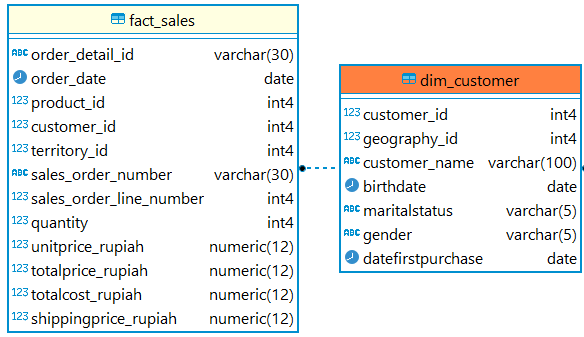

In [ ]:
%%bigquery --project  ds-bootcamp-sheila

SELECT
   (CASE
    WHEN (DATE_DIFF(current_date, birthdate, year)) <= 20 THEN 'GROUP <= 20'
    WHEN (DATE_DIFF(current_date, birthdate, year)) BETWEEN 21
  AND 40 THEN 'Group 21 - 40'
    WHEN (DATE_DIFF(current_date, birthdate, year)) BETWEEN 41 AND 60 THEN 'Group 41 - 60'
    WHEN (DATE_DIFF(current_date, birthdate, year)) >60 THEN 'Group > 60'
  ELSE
  'other'
END) as age_group,
gender, SUM(floor(totalprice_rupiah)) totalsales,
RANK() OVER (ORDER BY SUM(floor(totalprice_rupiah)) desc ) sales_rank
FROM
  `project_dibimbing_beecycle.dim_customer` dc
INNER JOIN (
  SELECT customer_id, totalprice_rupiah
  from `project_dibimbing_beecycle.fact_sales`) fs on dc.customer_id = fs.customer_id
  group by 1,2
  order by totalsales desc


Query is running:   0%|          |

Downloading:   0%|          |

,age_group,gender,totalsales,sales_rank
0,Group 41 - 60,F,1.974341e+10,1
1,Group 21 - 40,F,1.940950e+10,2
2,Group 21 - 40,M,1.861962e+10,3
3,Group 41 - 60,M,1.689372e+10,4
4,Group > 60,M,1.354304e+09,5
5,Group > 60,F,1.158323e+09,6


💡 ***The highest sales in BeeCycle are from females aged between 41 and 60 years old***


# Favorite Product Colors


As there will be a campaign next October, highlight a certain product color that is favored by customers. Then proceed to perform a query to answer the following question

**What is the most popular color purchased by customers each year?**

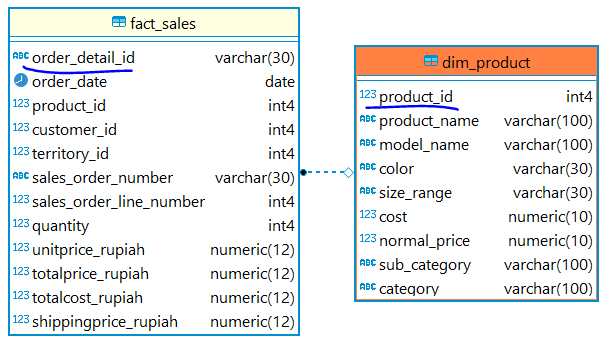

In [ ]:
#Tulis Query disini
%%bigquery --project  ds-bootcamp-sheila

SELECT
  DISTINCT EXTRACT(year
  FROM
    order_date) AS order_year,
  (
  SELECT
    color
  FROM (
    SELECT
      a.color,
      COUNT(b.quantity) AS sales_qty,
      rank() OVER (ORDER BY SUM(b.quantity) DESC) AS rank_type 
    FROM
      `project_dibimbing_beecycle.dim_product` a
    LEFT JOIN
      `project_dibimbing_beecycle.fact_sales` b
    ON
      b.product_id = a.product_id
    WHERE
      color != 'NA'
    GROUP BY
      a.color
    ORDER BY
      rank_type DESC )
  WHERE
    rank_type=1 ) AS bestseller

from
`project_dibimbing_beecycle.fact_sales` as year
group by
order_year
order by
order_year asc


Query is running:   0%|          |

Downloading:   0%|          |

,order_year,bestseller
0,2016,Black
1,2017,Black
2,2018,Black
3,2019,Black


💡***The most popular color purchased for each year is Black***

# Top 10 Products from Each Branch

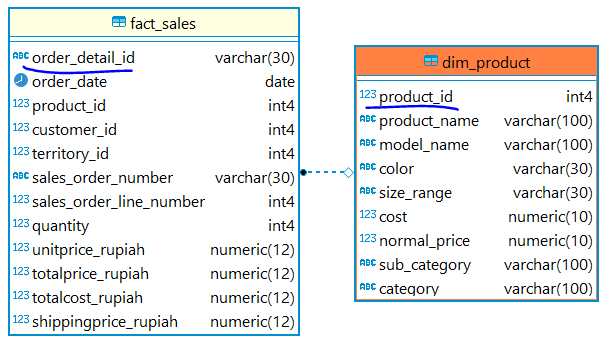

**What are the top 10 most popular product names in each territory?**

In [ ]:
#Tulis Query disini
%%bigquery --project  ds-bootcamp-sheila

SELECT territory_id,
    MAX(CASE WHEN rank = 1 THEN product_name ELSE NULL END) AS product_1,
    MAX(CASE WHEN rank = 2 THEN product_name ELSE NULL END) AS product_2,
    MAX(CASE WHEN rank = 3 THEN product_name ELSE NULL END) AS product_3,
    MAX(CASE WHEN rank = 4 THEN product_name ELSE NULL END) AS product_4,
    MAX(CASE WHEN rank = 5 THEN product_name ELSE NULL END) AS product_5,
    MAX(CASE WHEN rank = 6 THEN product_name ELSE NULL END) AS product_6,
    MAX(CASE WHEN rank = 7 THEN product_name ELSE NULL END) AS product_7,
    MAX(CASE WHEN rank = 8 THEN product_name ELSE NULL END) AS product_8,
    MAX(CASE WHEN rank = 9 THEN product_name ELSE NULL END) AS product_9,
    MAX(CASE WHEN rank = 10 THEN product_name ELSE NULL END) AS product_10
FROM (
    SELECT territory_id, product_name, RANK() OVER (PARTITION BY territory_id ORDER BY total_quantity DESC) as rank
    FROM (
        SELECT territory_id, product_id, SUM(quantity) as total_quantity
        FROM `project_dibimbing_beecycle.fact_sales`
        GROUP BY territory_id, product_id
    ) t
    JOIN `project_dibimbing_beecycle.dim_product` d ON t.product_id = d.product_id
) subq
WHERE rank <= 10
GROUP BY territory_id


Query is running:   0%|          |

Downloading:   0%|          |

,territory_id,product_1,product_2,product_3,product_4,product_5,product_6,product_7,product_8,product_9,product_10
0,10,Water Bottle - 30 oz.,"Sport-100 Helmet, Blue","Sport-100 Helmet, Red",None,Mountain Bottle Cage,Road Bottle Cage,"Sport-100 Helmet, Black",Touring Tire,"Mountain-200 Black, 42",Patch Kit/8 Patches
1,8,Water Bottle - 30 oz.,Mountain Bottle Cage,AWC Logo Cap,"Sport-100 Helmet, Black","Sport-100 Helmet, Red",None,"Sport-100 Helmet, Blue",None,Fender Set - Mountain,Touring Tire
2,9,Water Bottle - 30 oz.,Mountain Bottle Cage,"Sport-100 Helmet, Red",Fender Set - Mountain,"Sport-100 Helmet, Blue",None,Patch Kit/8 Patches,"Mountain-200 Silver, 38","Mountain-200 Black, 42",Mountain Tire Tube
3,4,HL Mountain Tire,Patch Kit/8 Patches,"Road-150 Red, 48",None,Mountain Tire Tube,"Road-150 Red, 56","Road-150 Red, 62","Road-150 Red, 52","Road-150 Red, 44",None
4,1,HL Mountain Tire,Patch Kit/8 Patches,Mountain Tire Tube,"Road-150 Red, 62","Road-150 Red, 48","Road-150 Red, 56","Road-150 Red, 44","Road-150 Red, 52",None,Water Bottle - 30 oz.
5,5,Water Bottle - 30 oz.,None,None,None,None,None,None,None,None,None
6,7,Water Bottle - 30 oz.,Road Bottle Cage,"Sport-100 Helmet, Blue",Mountain Bottle Cage,"Sport-100 Helmet, Red",Patch Kit/8 Patches,Touring Tire Tube,None,"Sport-100 Helmet, Black","Mountain-200 Black, 46"
7,6,Road Tire Tube,Patch Kit/8 Patches,Mountain Tire Tube,Touring Tire Tube,"Sport-100 Helmet, Black",None,Water Bottle - 30 oz.,None,None,LL Mountain Tire


# Potential Territory and Sales Period


Objective: As we aim to expand the business, we will examine which regions have the best sales potential and When is the period with the best sales in each region?

In [ ]:
#Tulis Query disini
%%bigquery --project  ds-bootcamp-sheila

WITH sales_by_region AS (
  SELECT 
    d.region,
    EXTRACT(YEAR FROM s.order_date) AS year,
    SUM(s.totalprice_rupiah) AS total_sales
  FROM 
    `project_dibimbing_beecycle.dim_territory` d
    JOIN `project_dibimbing_beecycle.fact_sales` s ON d.territory_id = s.territory_id
  GROUP BY 
    d.region, year
)
SELECT 
  year,
  region,
  total_sales
FROM (
  SELECT 
    year,
    region,
    total_sales,
    RANK() OVER (PARTITION BY year ORDER BY total_sales DESC) AS sales_rank
  FROM 
    sales_by_region
)
WHERE 
  sales_rank = 1
ORDER BY 
  year



Query is running:   0%|          |

Downloading:   0%|          |

,year,region,total_sales
0,2016,Southwest,4.906891e+09
1,2017,Australia,6.420778e+09
2,2018,Australia,9.198201e+09
3,2019,Australia,7.217024e+09


💡***Australia has had the best sales for three consecutive years***

In [ ]:
%%bigquery --project  ds-bootcamp-sheila
WITH sales_by_period AS (
  SELECT 
    t.region,
    EXTRACT(YEAR FROM fs.order_date) AS year,
    EXTRACT(MONTH FROM fs.order_date) AS month,
    SUM(fs.totalprice_rupiah) AS total_sales
  FROM 
    `project_dibimbing_beecycle.dim_territory` t
  JOIN 
    `project_dibimbing_beecycle.fact_sales` fs
  ON 
    t.territory_id = fs.territory_id
  GROUP BY 
    t.region,
    year,
    month
)
SELECT 
  sbp.region,
  sbp.year,
  sbp.month,
  sbp.total_sales
FROM 
  sales_by_period sbp
JOIN (
  SELECT 
    region,
    MAX(total_sales) AS max_sales
  FROM 
    sales_by_period
  GROUP BY 
    region
) max_sales_by_region
ON 
  sbp.region = max_sales_by_region.region
  AND sbp.total_sales = max_sales_by_region.max_sales
ORDER BY 
  sbp.month ASC


Query is running:   0%|          |

Downloading:   0%|          |

,region,year,month,total_sales
0,Germany,2019,1,7.696935e+08
1,United Kingdom,2019,2,7.816873e+08
2,Australia,2019,2,2.482067e+09
3,Southeast,2019,2,3.357858e+07
4,Canada,2017,2,1.462565e+09
5,Southwest,2017,3,1.653161e+09
6,France,2018,7,7.794816e+08
7,Northwest,2016,12,1.052011e+09


💡 ***Based on the fact that Australia has had the best sales for three consecutive years, we will now focus on expanding the business in Australia. Additionally, the best period to conduct a campaign would be in Quarter 1***